# Model 2: Multi-Variate

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

df = pd.read_csv('Dataframes/3rdBodyPerturbationPoliastro.csv')
df_v = pd.read_csv('Dataframes/3rdBodyPerturbationPoliastro_vv.csv')

df['x_vv']=df_v.vv_x
df['y_vv']=df_v.vv_y
df['z_vv']=df_v.vv_z

df

,x,y,z,x_vv,y_vv,z_vv
0,42159.783600,0.000000,0.000000,0.000000,3.074505,0.053666
1,39159.545914,15563.916303,266.913399,-1.142984,2.852848,0.048528
2,30572.229294,28909.053086,496.928223,-2.127756,2.228986,0.039518
3,17596.068412,38144.740319,671.356184,-2.813645,1.287415,0.027234
4,2068.446366,41949.706443,775.646554,-3.098444,0.161675,0.012698
...,...,...,...,...,...,...
995,38132.961517,21370.880108,-7532.333000,-0.876644,2.199413,1.750026
996,31399.515894,31233.289707,1828.575655,-1.692745,1.562118,1.820311
997,20906.077447,37238.565267,10967.804062,-2.312211,0.726117,1.664753
998,7871.245318,38575.122415,18731.818721,-2.661184,-0.221639,1.293445


Double precision landed worse results/conv didn't improve at all.

In [3]:
predicted_feature = 0 # input number from 0 to 5, coresponds to x,y,z,vv_x,vv_y,vv_z

In [4]:
# convert an array of values into a dataset matrix

def create_dataset(dataset, look_back):
    dataX = []
    dataY = []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, predicted_feature]) # 2 stands for prediction of Z!!! (3rd col)
    return np.array(dataX), np.array(dataY)

In [5]:
# load the dataset
dataset = df.values

In [6]:
# split into train and test sets
train_size = int(len(dataset) * 0.8) 
test_size = len(dataset) - train_size

train=dataset[0 : train_size]
test=dataset[train_size - 60 : ]

In [7]:
train.shape

(800, 6)

In [8]:
#Scale the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train = scaler.fit_transform(train)
test = scaler.transform(test)

# reshape into X=t and Y=t+1
look_back = 60 # this is the window
trainX, trainY = create_dataset(train, look_back)  
testX, testY = create_dataset(test, look_back)

# reshape input to be  [length of train/test data, window size (def=60), features]
trainX = np.reshape(trainX, (trainX.shape[0], look_back, 6))
testX = np.reshape(testX, (testX.shape[0],look_back, 6))

In [9]:
trainX.shape

(740, 60, 6)

In [10]:
testX.shape

(200, 60, 6)

In [11]:
testY.shape

(200,)

Epoch 1/100
3/3 [==============================] - 1s 361ms/step - loss: 0.1594
Epoch 2/100
3/3 [==============================] - 1s 365ms/step - loss: 0.0924
Epoch 3/100
3/3 [==============================] - 1s 354ms/step - loss: 0.0697
Epoch 4/100
3/3 [==============================] - 1s 344ms/step - loss: 0.0369
Epoch 5/100
3/3 [==============================] - 1s 356ms/step - loss: 0.0144
Epoch 6/100
3/3 [==============================] - 1s 340ms/step - loss: 0.0081
Epoch 7/100
3/3 [==============================] - 1s 348ms/step - loss: 0.0109
Epoch 8/100
3/3 [==============================] - 1s 334ms/step - loss: 0.0091
Epoch 9/100
3/3 [==============================] - 1s 355ms/step - loss: 0.0050
Epoch 10/100
3/3 [==============================] - 1s 329ms/step - loss: 0.0026
Epoch 11/100
3/3 [==============================] - 1s 340ms/step - loss: 0.0031
Epoch 12/100
3/3 [==============================] - 1s 350ms/step - loss: 0.0036
Epoch 13/100
3/3 [===================

3/3 [==============================] - 1s 431ms/step - loss: 1.0417e-04
Epoch 99/100
3/3 [==============================] - 1s 411ms/step - loss: 1.2693e-04
Epoch 100/100
3/3 [==============================] - 1s 484ms/step - loss: 1.6695e-04


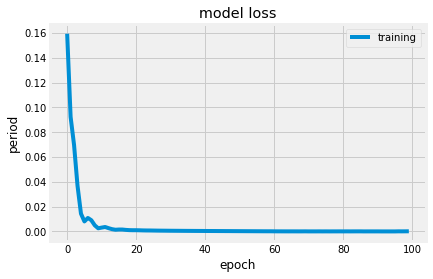

In [12]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
# Note: replace LSTM with GRU or RNN if you want to try those
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (look_back, 6)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history=model.fit(trainX, trainY, batch_size=256, epochs=100)

# Plot Training Loss
plt.plot(history.history['loss']) # add validation loss
plt.title('model loss')
plt.ylabel('period')
plt.xlabel('epoch')
plt.legend(['training'], loc='upper right')
plt.show()

**Obs:** 25 Epochs will do for good convergence.

In [13]:
predictions = model.predict(testX)

predict_ext = np.zeros((len(predictions), 6))
predict_ext[:,predicted_feature] = predictions[:,0]
predictions = scaler.inverse_transform(predict_ext)[:,predicted_feature]

In [14]:
testY_extended = np.zeros((len(testY),6))
testY_extended[:,predicted_feature]=testY
testY=scaler.inverse_transform(testY_extended)[:,predicted_feature]

In [15]:
# RMSE
rmse = np.sqrt(np.mean(((predictions - testY) ** 2)))
rmse

989.1833872651068

In [16]:
# Plot the data
train = df[:train_size]
test = df[train_size:]

In [17]:
dataa = {'testY': testY, 'predictions': predictions}
dff = pd.DataFrame.from_dict(dataa)

Plot:

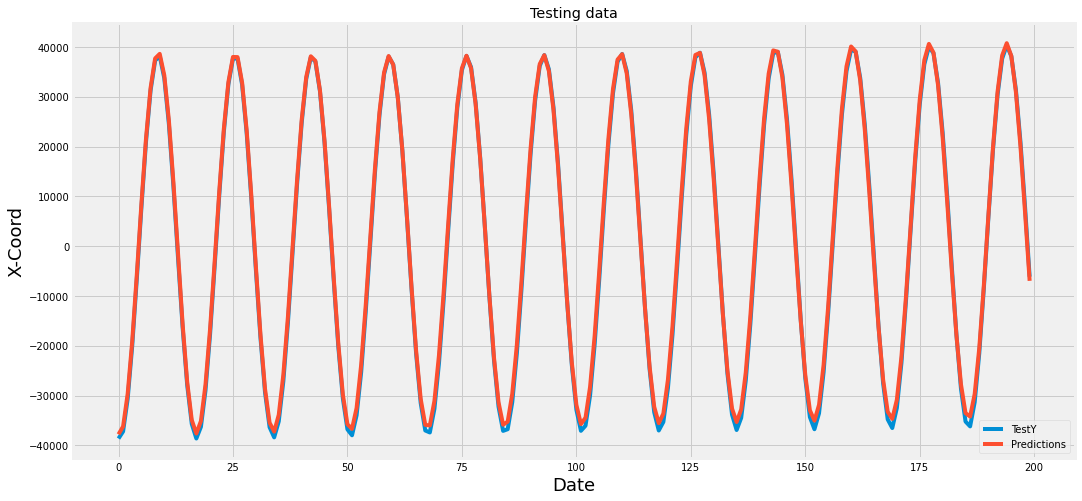

In [18]:
plt.figure(figsize=(16,8))
plt.title('Testing data')
plt.xlabel('Date', fontsize=18)
plt.ylabel('X-Coord', fontsize=18)
plt.plot(dff.testY)
plt.plot(dff.predictions)
plt.legend(['TestY', 'Predictions'], loc='lower right')
plt.show()

Absolute Error plot:

<AxesSubplot:>

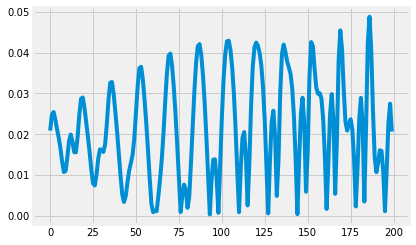

In [19]:
dff['Error']=abs(dff.predictions-dff.testY)/max(dff.testY) # the normalization ct is taken as ISS semi-major axis
dff.Error.plot()

Relative Error plot:

<AxesSubplot:>

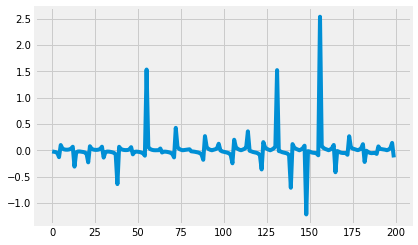

In [20]:
dff['Error']=abs(dff.predictions-dff.testY)/dff.testY # the normalization ct is taken as ISS semi-major axis
dff.Error.plot()
# for 3D case take NORM of these!!!

## This is how we predict one of the coordinates based on the 6 features.